# Forecasting (Prophet & ARIMA)

**Objective.** Forecast weekly Instacart demand signals to support planning and experimentation.

- **Targets:** `weekly_orders` (count), `weekly_reorder_rate` (ratio 0–1)
- **Models:** Baselines (Naive, Seasonal-Naive, MovingAvg), Prophet, SARIMA
- **Why it matters:** anticipate volume, time promotions, manage capacity/inventory

**What this notebook does**

1) **Loads & minimally QC’s data** — auto detects Instacart CSVs, checks required columns, and shows quick previews.  
2) **Builds weekly targets** — constructs a safe pseudo-calendar and creates `weekly_orders` (count; gaps→0) and `weekly_reorder_rate` (ratio; gaps interpolated, clipped to [0,1]).  
3) **Runs diagnostics** — reports trend %, week-over-week volatility, and autocorr@52 + span/range sanity.  
4) **Splits data temporally** — train / validation / test in weekly steps with guardrails; plots split markers.  
5) **Scores baselines** — Naive, Seasonal-Naive, MovingAvg-4 using MAE/RMSE/MAPE/sMAPE/MASE; builds a validation leaderboard.  
6) **Fits Prophet & SARIMA** — trains on the same validation window; compares to baselines and saves plots.  
7) **Refits the best model on train+val** — evaluates once on the held out test window; saves test predictions and figure.  
8) **Generates the final +H forecast** — fits on all history; saves forecast CSV and plot.  
9) **Runs a rolling backtest (optional)** — k-folds on train+val to check stability; aggregates mean metrics by model.  
10) **Exposes repro knobs** — tweak `CONFIG.val_weeks`, `CONFIG.test_weeks`, `CONFIG.horizon_weeks`, `CONFIG.seasonal_period_weeks`, `CONST.BACKTEST_FOLDS`, `CONST.BACKTEST_STEP_WEEKS`, `CONST.DATE_ANCHOR`, `CONST.FREQ_WEEK`.

**How to run**
1. Ensure data exists under `../datasets` or `../data` (auto-detected).
2. Update **CONFIG** (validation/test sizes, horizon, seasonal period).
3. Run cells top→bottom. Artifacts go to `artifacts/forecasting/`, figures to `reports/figures/forecasting/`.

#### Notebook Setup

**What this does:** initialize libraries, optional dependencies, and project paths.

- **Optional deps (graceful fallback):**
  - `prophet` (or `fbprophet`) → set to `None` if missing
  - `pmdarima` (SARIMA via `auto_arima`) → set to `None` if missing
  - `tqdm` (progress), `holidays` (regressor) → optional

- **Project paths:** `PROJECT_ROOT`, `DATA_PATH`, `ART_DIR`, `FIG_DIR`  
  Artifacts land in `artifacts/forecasting/`, figures in `reports/figures/forecasting/`.

- **Knobs you can tweak (top of notebook):**
  - `CONFIG.val_weeks`, `CONFIG.test_weeks`, `CONFIG.horizon_weeks`
  - `CONFIG.seasonal_period_weeks` (used by Seasonal-Naive & MASE)
  - `CONST.BACKTEST_FOLDS`, `CONST.BACKTEST_STEP_WEEKS`
  - `CONST.DATE_ANCHOR`, `CONST.FREQ_WEEK` (pseudo-calendar)

*Tip: The printout at the end of this cell confirms which packages are available and whether the expected CSVs exist under `DATA_PATH`.*

In [1]:
# Imports (Prophet + SARIMA focus)
import os, warnings
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display
from pandas.tseries.frequencies import to_offset  # used later for future date ranges

# Statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

warnings.filterwarnings("ignore")

# Prophet (with fallback to fbprophet)
try:
    from prophet import Prophet
except Exception:
    try:
        from fbprophet import Prophet
    except Exception:
        Prophet = None  # we'll skip Prophet gracefully if unavailable

# ARIMA / SARIMA via pmdarima (auto_arima)
try:
    import pmdarima as pm
except Exception:
    pm = None

# Scikit-learn 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Progress bar (optional)
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k): return x

# Holidays (optional external regressor for Prophet)
try:
    import holidays
    US_HOLIDAYS = holidays.UnitedStates()
except Exception:
    US_HOLIDAYS = None

# Paths & config
PROJECT_ROOT = Path(".")
DATA_PATH    = (PROJECT_ROOT / ".." / "data").resolve()    # change to ../datasets/<your-folder> if you use a central datasets/
ART_DIR      = (PROJECT_ROOT / ".." / "artifacts" / "forecasting").resolve()
FIG_DIR      = (PROJECT_ROOT / ".." / "reports" / "figures" / "forecasting").resolve()

CONFIG = {
    "use_targets": ["weekly_orders", "weekly_reorder_rate"],
    "val_weeks": 6,
    "test_weeks": 6,
    "horizon_weeks": 12,
    "seed": 42,
    "seasonal_period_weeks": 52
}

CONST = SimpleNamespace(
    RUN_NAME="04_forecasting_prophet_arima",
    DATE_ANCHOR=pd.Timestamp("2017-01-01"),
    FREQ_WEEK="W-SUN",
    RANDOM_SEED=CONFIG["seed"],
    FIG_DPI=144,
    FIGSIZE=(9, 4),
    VERBOSE=True,
    BACKTEST_FOLDS=4,
    BACKTEST_STEP_WEEKS=4
)

np.random.seed(CONST.RANDOM_SEED)

# Ensure output dirs
for p in [ART_DIR, FIG_DIR]:
    os.makedirs(p, exist_ok=True)

# Environment banner (helps readers know what's available)
print(
    f"DATA_PATH: {DATA_PATH}\n"
    f"Prophet available: {Prophet is not None} | pmdarima available: {pm is not None}\n"
    f"orders.csv exists: {(DATA_PATH/'orders.csv').exists()} | "
    f"order_products__prior.csv exists: {(DATA_PATH/'order_products__prior.csv').exists()}"
)
if not (DATA_PATH/'orders.csv').exists():
    print("Hint: If you use a central datasets/ folder, point DATA_PATH to it, e.g.:")
    print("DATA_PATH = (PROJECT_ROOT / '..' / 'datasets' / 'instacart').resolve()")


DATA_PATH: /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/data
Prophet available: True | pmdarima available: False
orders.csv exists: False | order_products__prior.csv exists: False
Hint: If you use a central datasets/ folder, point DATA_PATH to it, e.g.:
DATA_PATH = (PROJECT_ROOT / '..' / 'datasets' / 'instacart').resolve()


#### Load & Minimal QC

**What this does:** fast, lightweight loading + schema checks so we can focus on forecasting.

- **Search roots (in order):** project root, `../data`, `../datasets`, and this notebook’s folder  
  *(Override by directly setting `DATA_PATH` if needed.)*

- **Filename candidates (auto-detect):**
  - **Orders:** `orders_clean.csv`, `instacart_orders.csv`, `orders.csv`
  - **Line items:** `order_products_clean.csv`, `order_products__prior.csv`, `order_products.csv`

- **Schema (minimal columns actually used):**
  - `orders`: `order_id`, `user_id`, `order_number`, `days_since_prior_order`
  - `line items`: `order_id`, `product_id`, `reordered`

- **What you’ll see:** chosen file paths, shapes, `head()`/`tail()`, top 10 nulls, and dtypes for required cols.

- 

*If you see _“Using TRAIN/RAW as proxy for PRIOR”_, the loader didn’t find `order_products__prior.csv` and fell back to a compatible file. That’s fine for this notebook’s rate aggregation, but keep it in mind when interpreting results.*

In [2]:
# Load & Preview 

# Where to search (add/remove roots to taste)
SEARCH_ROOTS = [
    Path(".").resolve(),                     # ./notebooks
    Path(".").resolve().parent,             # project root
    Path(".").resolve().parent / "data",    # ../data
    Path(".").resolve().parent / "datasets" # ../datasets  (your screenshot)
]

# Candidate filenames (order = preference)
ORDER_CANDIDATES = ["orders_clean.csv", "instacart_orders.csv", "orders.csv"]
LINES_CANDIDATES = ["order_products_clean.csv", "order_products__prior.csv", "order_products.csv"]

ORDERS_REQ_MIN = {"order_id","user_id","order_number","days_since_prior_order"}  # minimal set actually used
LINES_REQ      = {"order_id","product_id","reordered"}

def _find_first(roots, names):
    hits = []
    for root in roots:
        if not root.exists():
            continue
        for name in names:
            hits += list(root.rglob(name))
    if not hits:
        return None
    # choose the shallowest path (nicer) and prefer earlier candidate names
    def score(p):
        # lower is better: (index of candidate name, path depth)
        cand_idx = next((i for i,n in enumerate(names) if p.name == n), len(names))
        return (cand_idx, len(p.parts))
    return sorted(hits, key=score)[0]

def resolve_files():
    orders_fp = _find_first(SEARCH_ROOTS, ORDER_CANDIDATES)
    lines_fp  = _find_first(SEARCH_ROOTS, LINES_CANDIDATES)
    if orders_fp is None:
        raise FileNotFoundError(f"Could not find any of {ORDER_CANDIDATES} under: " + ", ".join(map(str, SEARCH_ROOTS)))
    if lines_fp is None:
        raise FileNotFoundError(f"Could not find any of {LINES_CANDIDATES} under: " + ", ".join(map(str, SEARCH_ROOTS)))
    print("Using orders     →", orders_fp)
    print("Using line items →", lines_fp)
    return orders_fp.parent, orders_fp, lines_fp

DATA_PATH, ORDERS_FP, LINES_FP = resolve_files()

def load_data(orders_fp: Path = ORDERS_FP, lines_fp: Path = LINES_FP, verbose: bool = True) -> SimpleNamespace:
    import pandas as pd

    orders = pd.read_csv(orders_fp)
    lines  = pd.read_csv(lines_fp)

    # schema checks (minimal columns we actually need)
    miss_o = ORDERS_REQ_MIN - set(orders.columns)
    miss_l = LINES_REQ - set(lines.columns)
    if miss_o:
        raise AssertionError(f"{orders_fp.name} missing required cols: {miss_o}")
    if miss_l:
        raise AssertionError(f"{lines_fp.name} missing required cols: {miss_l}")

    # keep only the columns we use downstream
    orders = orders[list(ORDERS_REQ_MIN)].copy()
    lines  = lines[list(LINES_REQ)].copy()

    if verbose:
        print(f"Loaded orders {orders.shape}  ← {orders_fp.name}")
        print(f"Loaded lines  {lines.shape}   ← {lines_fp.name}")
        if "train" in lines_fp.name and "prior" not in lines_fp.name:
            print("Using TRAIN/RAW lines as proxy for PRIOR; reorder rate reflects that subset.")

    from types import SimpleNamespace
    return SimpleNamespace(orders=orders, op_prior=lines)

# Compact preview helper
def peek(df, name: str, n: int = 3):
    from IPython.display import display
    print(f"\n— {name} — shape={df.shape}")
    display(df.head(n)); display(df.tail(n))
    nulls = df.isna().sum()
    if nulls.any():
        print("Top nulls:"); display(nulls[nulls>0].sort_values(ascending=False).head(10))
    print("Dtypes:"); display(df.dtypes)

# Load & preview
D = load_data()
peek(D.orders, "orders")
peek(D.op_prior, "order_products (prior/train/clean)")

Using orders     → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/datasets/clean/orders_clean.csv
Using line items → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/datasets/clean/order_products_clean.csv
Loaded orders (478967, 4)  ← orders_clean.csv
Loaded lines  (4544317, 3)   ← order_products_clean.csv

— orders — shape=(478967, 4)


,user_id,order_number,order_id,days_since_prior_order
0,183418,11,1515936,30.0
1,163593,5,1690866,9.0
2,39980,4,1454967,2.0


,user_id,order_number,order_id,days_since_prior_order
478964,82944,16,885349,6.0
478965,4391,3,216274,8.0
478966,1730,18,2071924,15.0


Top nulls:


days_since_prior_order    28819
dtype: int64

Dtypes:


user_id                     int64
order_number                int64
order_id                    int64
days_since_prior_order    float64
dtype: object


— order_products (prior/train/clean) — shape=(4544317, 3)


,product_id,reordered,order_id
0,11440,0,2141543
1,1560,1,567889
2,26683,1,2261212


,product_id,reordered,order_id
4544314,47766,1,692640
4544315,691,1,319435
4544316,28733,0,1398151


Dtypes:


product_id    int64
reordered     int64
order_id      int64
dtype: object

**Quick read:** Files resolved, schemas OK, and minimal previews look sane → proceed to target construction.


#### Weekly Targets — Consistent Pseudo-Calendar

- **What & why.** Create two model ready weekly series on a consistent timeline so Prophet/SARIMA can ingest them:
  - `weekly_orders` — unique orders per week (**count**)
  - `weekly_reorder_rate` — sum(reordered) / count(lines) per week (**ratio**)
  This standardizes irregular user timelines (some users order daily, others monthly) into a single weekly index.

- **How it works.**
  1) For each user, build a timeline from `days_since_prior_order` and compute  
     \(\texttt{week\_index} = \left\lfloor \frac{\texttt{cumsum(days\_since\_prior\_order)}}{7} \right\rfloor\).
  2) Aggregate by `week_index`:  
     • orders: `n_unique(order_id)` → **weekly_orders**  
     • reorders: `sum(reordered) / count(lines)` → **weekly_reorder_rate**  
  3) Map to dates: `ds = DATE_ANCHOR + 7 * week_index`, reindex to weekly `FREQ_WEEK`.
  4) Gap handling: **counts → 0-fill**, **rates → interpolate**, then **clip to [0,1]**.

- **How to read it.**
  - A late-series decline in **weekly_orders** reflects **fewer users reaching late weeks** (cohort attrition), not a real calendar drop.
  - **weekly_reorder_rate** is scale free; watch its level and smoothness. Sharp moves near the tail often mean **small denominators**.
  - Use these as the canonical inputs for baseline models and short horizon forecasts.

- **Caveats.**
  - This is a **pseudo-calendar**; if business questions need real dates, rebuild by **calendar week** using actual order timestamps.
  - History is shorter than a full 52 week season, so seasonal effects may be weak.

In [4]:
# Build Weekly Targets (safe calendar + summaries)

def build_weekly_targets(
    orders: pd.DataFrame,
    op_prior: pd.DataFrame,
    *,
    anchor: pd.Timestamp = getattr(CONST, "DATE_ANCHOR", pd.Timestamp("2017-01-01")),
    freq: str = getattr(CONST, "FREQ_WEEK", "W-SUN"),
) -> dict[str, pd.DataFrame]:
    """
    Build two weekly time series on a consistent calendar:
      - weekly_orders:        unique orders per week
      - weekly_reorder_rate:  reorders / lines per week
    Steps:
      1) Per-user cumulative day timeline from days_since_prior_order
      2) week_index = floor(timeline_day/7)
      3) Aggregate targets by week_index
      4) Map to weekly dates from `anchor`, reindex to full calendar, fill gaps
    """
    # Per-user weekly index
    or0 = orders[["order_id","user_id","order_number","days_since_prior_order"]].copy()
    or0 = or0.sort_values(["user_id","order_number"])
    or0["days_since_prior_order"] = or0["days_since_prior_order"].fillna(0)
    or0["week_index"] = (or0.groupby("user_id")["days_since_prior_order"].cumsum() // 7).astype(int)

    # Target A: unique orders per week (count) 
    w_orders = (or0.groupby("week_index", as_index=False)["order_id"]
                   .nunique()
                   .rename(columns={"order_id": "y"}))

    # Target B: weekly reorder rate = sum(reordered) / count(lines) (rate)
    op1 = op_prior.merge(or0[["order_id","week_index"]], on="order_id", how="left").dropna(subset=["week_index"])
    op1["week_index"] = op1["week_index"].astype(int)
    agg = op1.groupby("week_index", as_index=False).agg(lines=("reordered","size"), reorders=("reordered","sum"))
    agg["y"] = np.where(agg["lines"] > 0, agg["reorders"] / agg["lines"], np.nan)
    w_reord = agg[["week_index","y"]]

    # Helper: convert week_index → weekly {ds,y} series with controlled gap filling
    def to_weekly(df: pd.DataFrame, *, method: str) -> pd.DataFrame:
        df = (df.assign(ds = anchor + pd.to_timedelta(df["week_index"] * 7, unit="D"))
                .drop(columns="week_index")
                .sort_values("ds")
                .reset_index(drop=True))
        idx = pd.date_range(df["ds"].min(), df["ds"].max(), freq=freq)
        out = df.set_index("ds").reindex(idx).rename_axis("ds").reset_index()
        if method == "zero":          # counts
            out["y"] = out["y"].fillna(0)
        else:                         # rates/continuous
            out["y"] = out["y"].interpolate().bfill().ffill()
        return out

    before = {"weekly_orders": len(w_orders), "weekly_reorder_rate": len(w_reord)}
    s_orders = to_weekly(w_orders, method="zero")
    s_reord  = to_weekly(w_reord,  method="interpolate")
    s_reord["y"] = s_reord["y"].clip(0, 1)
    after  = {"weekly_orders": len(s_orders), "weekly_reorder_rate": len(s_reord)}

    if getattr(CONST, "VERBOSE", False):
        for name, df in [("weekly_orders", s_orders), ("weekly_reorder_rate", s_reord)]:
            filled = after[name] - before[name]
            print(f"{name}: {before[name]}→{after[name]} weeks (filled {filled}) | "
                  f"{df['ds'].min().date()} → {df['ds'].max().date()}")

    return {"weekly_orders": s_orders, "weekly_reorder_rate": s_reord}


weekly_orders: 27→28 weeks (filled 1) | 2017-01-01 → 2017-07-09
weekly_reorder_rate: 26→26 weeks (filled 0) | 2017-01-01 → 2017-06-25


,target,weeks,start,end,y_min,y_max
0,weekly_orders,28,2017-01-01,2017-07-09,0.0000,79194.0000
1,weekly_reorder_rate,26,2017-01-01,2017-06-25,0.2961,0.9512



weekly_orders preview


,ds,y
0,2017-01-01,79194.0
1,2017-01-08,76973.0
2,2017-01-15,64600.0


,ds,y
25,2017-06-25,2.0
26,2017-07-02,0.0
27,2017-07-09,1.0



weekly_reorder_rate preview


,ds,y
0,2017-01-01,0.296130
1,2017-01-08,0.582302
2,2017-01-15,0.635563


,ds,y
23,2017-06-11,0.833333
24,2017-06-18,0.636364
25,2017-06-25,0.368421


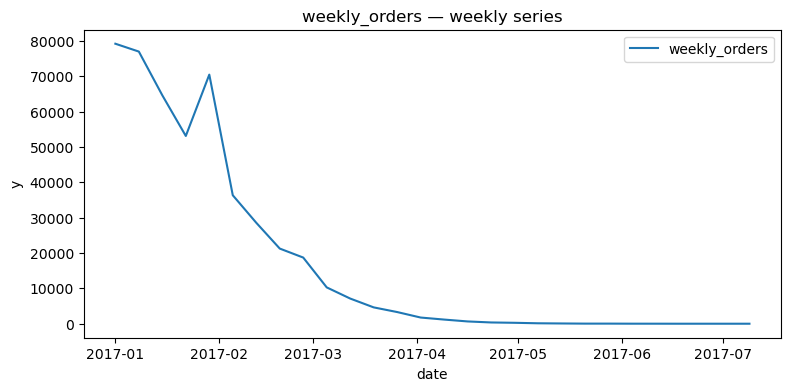

Saved plot → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/reports/figures/forecasting/weekly_orders_series_quick.png


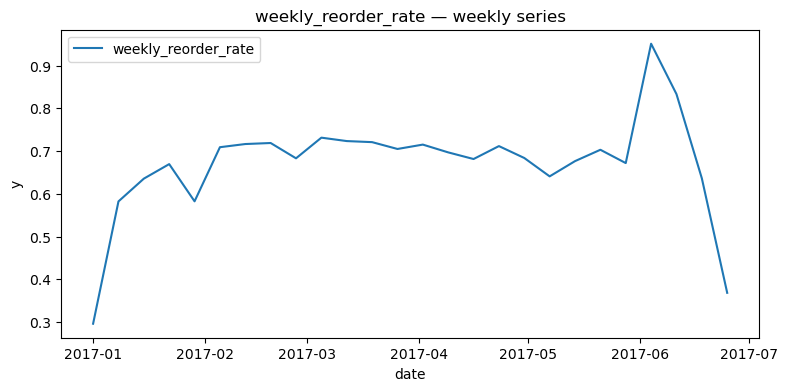

Saved plot → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/reports/figures/forecasting/weekly_reorder_rate_series_quick.png


In [5]:
# Run & Display — Data load & schema check
# Quick check helper (summary table + small previews)
def target_quick_check(targets: dict[str, pd.DataFrame], n: int = 3) -> pd.DataFrame:
    rows = []
    for name, df in targets.items():
        df = df.sort_values("ds").reset_index(drop=True)
        rows.append({
            "target": name,
            "weeks": len(df),
            "start": df["ds"].min().date(),
            "end":   df["ds"].max().date(),
            "y_min": round(float(df["y"].min()), 4),
            "y_max": round(float(df["y"].max()), 4),
        })
    summary = pd.DataFrame(rows).sort_values("target")
    display(summary)

    for name, df in targets.items():
        print(f"\n{name} preview")
        display(df.head(n)); display(df.tail(n))
        if name == "weekly_reorder_rate":
            y_min, y_max = float(df["y"].min()), float(df["y"].max())
            if not (0.0 <= y_min <= 1.0 and 0.0 <= y_max <= 1.0):
                print("reorder_rate out of [0,1] — double-check join/aggregation.")
    return summary


# Run & Display (call the functions to show results) 
# Assumes `D` exists from your Load & Preview cell.
targets = build_weekly_targets(D.orders, D.op_prior)
_ = target_quick_check(targets)

# Tiny visual per target (also saves to reports/figures/forecasting/)
for name, df in targets.items():
    s = df.sort_values("ds")
    plt.figure(figsize=CONST.FIGSIZE)
    plt.plot(s["ds"], s["y"], label=name)
    plt.title(f"{name} — weekly series"); plt.xlabel("date"); plt.ylabel("y"); plt.legend()
    out = FIG_DIR / f"{name}_series_quick.png"
    plt.savefig(out, dpi=CONST.FIG_DPI, bbox_inches="tight"); plt.show()
    print("Saved plot →", out)


#### Findings — Weekly Targets (Series View)

**At a glance**
- `weekly_orders`: sharp decline from ~79k in early weeks to ~0 near the tail (28 weeks total after 0-fill).
- `weekly_reorder_rate`: mostly stable ~0.64–0.72, with a late spike and final drop (26 weeks, interpolated & clipped to [0,1]).

**How to read these**
- The **decline in `weekly_orders` is cohort attrition**, not a real calendar trend. As weeks progress, fewer users have reached those late weeks in the pseudo-timeline, so counts naturally fall toward zero.
- `weekly_reorder_rate` is **scale-free**; level and smoothness matter more than slope.  
  The **late spike/drop** is typical when denominators (lines) get small near the series tail.

**Implications**
- Treat `weekly_orders` as a **diagnostic** under the pseudo-calendar, not a literal “weekly demand” time series.  
  For calendar decisions, rebuild by **true calendar week** using real timestamps.
- `weekly_reorder_rate` is a good candidate for short horizon baselines; expect simple models (Naive / Seasonal-Naive) to be competitive.

**Recommended actions**
- **Forecasting setup:** use these two targets as inputs to baselines and (if available) Prophet/SARIMA; prefer the simpler model if validation sMAPE is close.
- **Stability:** consider trimming the last 1–2 weeks (tail) or use rolling backtests to check that spikes don’t dominate metrics.
- **Data improvement:** if business reporting needs real calendar alignment (e.g., week-over-week demand), rebuild with **calendar week** aggregation.

**Artifacts saved**
- Series plots: `reports/figures/forecasting/weekly_orders_series_quick.png`,  
  `reports/figures/forecasting/weekly_reorder_rate_series_quick.png`


#### Temporal Split — Train / Validation / Test (weekly)

**What & why.** Chronologically partition each target to evaluate generalization and select models without leaking future information.

**How it works**
1) Sort by `ds`; let `n = len(series)`.  
2) Bound windows by history:  
   - `test_weeks = min(CONFIG.test_weeks, n)`  
   - `val_weeks  = min(CONFIG.val_weeks,  n - test_weeks)`  
3) Indices:  
   - `train = [0 : n - (val_weeks + test_weeks))`  
   - `val   = [train_end : test_start)`  
   - `test  = [test_start : n)`  
4) Return **markers** used to draw the vertical dashed lines on the split plot.

**How to read the plot/table**
- Dashed lines mark **train end** and **val end**.  
- If `val` is empty, reduce `CONFIG.val_weeks`/`CONFIG.test_weeks`.  
- Very short `train` means MASE uses a small in-sample window—interpret scores accordingly.

**Knobs**
- `CONFIG.val_weeks`, `CONFIG.test_weeks` (try 4–6 for short series)  
- Final forecast horizon is independent: `CONFIG.horizon_weeks`.

**Notes**
- Split is purely temporal; no shuffling.  
- Guardrails ensure we never request more weeks than exist.

Split → train=16 (2017-01-01→2017-04-16), val=6 (2017-04-23→2017-05-28), test=6 (2017-06-04→2017-07-09)

weekly_orders split summary


,part,weeks,start,end
0,train,16,2017-01-01,2017-04-16
1,val,6,2017-04-23,2017-05-28
2,test,6,2017-06-04,2017-07-09


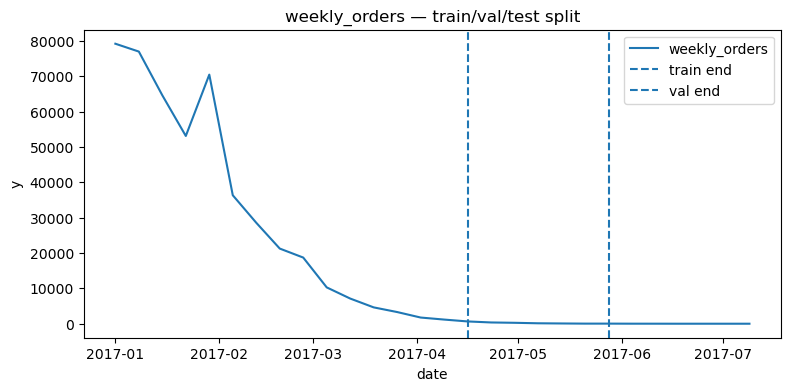

Saved split plot → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/reports/figures/forecasting/weekly_orders_split.png
Split → train=14 (2017-01-01→2017-04-02), val=6 (2017-04-09→2017-05-14), test=6 (2017-05-21→2017-06-25)

weekly_reorder_rate split summary


,part,weeks,start,end
0,train,14,2017-01-01,2017-04-02
1,val,6,2017-04-09,2017-05-14
2,test,6,2017-05-21,2017-06-25


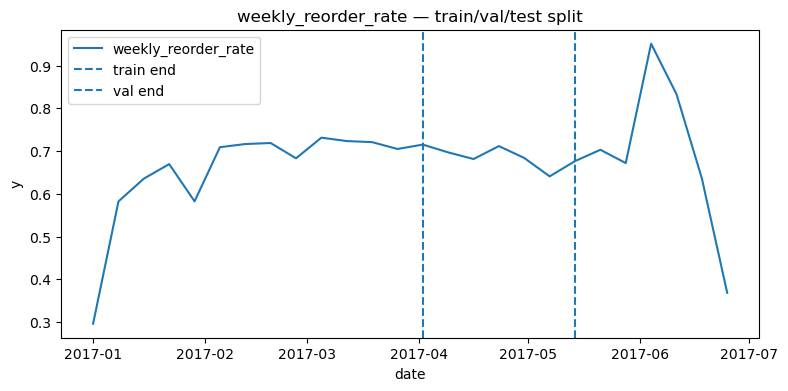

Saved split plot → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/reports/figures/forecasting/weekly_reorder_rate_split.png


In [6]:
# Temporal Split (Robust + Readable)

def temporal_split(
    df: pd.DataFrame,
    val_weeks: int,
    test_weeks: int,
    *,
    min_train_weeks: int = 8,
    strict: bool = False,
    return_markers: bool = True,
):
    """
    Split a weekly series (columns: ['ds','y']) into train | val | test by counts.

    - Preserves requested val/test sizes when possible.
    - If history is short, shrinks train (and, if needed, val) but never makes sizes negative.
    - Set `strict=True` to raise if train < min_train_weeks.

    Returns
    -------
    (train, val, test[, markers])
    markers = {'train_end_idx': int, 'val_end_idx': int} for plotting if return_markers=True.
    """
    df = df.sort_values("ds").reset_index(drop=True)
    n  = len(df)

    # Bound requested windows by available history
    test_weeks = max(0, min(test_weeks, n))
    test_start = n - test_weeks
    val_weeks  = max(0, min(val_weeks, test_start))
    val_start  = test_start - val_weeks

    train = df.iloc[:max(val_start, 0)].copy()
    val   = df.iloc[max(val_start, 0):test_start].copy()
    test  = df.iloc[test_start:].copy()

    # Guardrail: warn/raise on too-short train
    if len(train) < min_train_weeks:
        msg = (f"Short train: {len(train)} < {min_train_weeks} weeks. "
               f"Consider reducing val/test (asked val={val_weeks}, test={test_weeks}).")
        if strict:
            raise ValueError(msg + f" Series length={n}.")
        elif getattr(CONST, "VERBOSE", False):
            print("!!!", msg)

    if getattr(CONST, "VERBOSE", False):
        def span(d): 
            return f"{d['ds'].min().date()}→{d['ds'].max().date()}" if len(d) else "∅"
        print(f"Split → train={len(train)} ({span(train)}), "
              f"val={len(val)} ({span(val)}), test={len(test)} ({span(test)})")

    if return_markers:
        markers = {
            "train_end_idx": len(train) - 1 if len(train) else None,
            "val_end_idx":   len(train) + len(val) - 1 if len(val) else len(train) - 1
        }
        return train, val, test, markers
    return train, val, test


# Run & Display: apply split + quick plot for each target 
for name in CONFIG["use_targets"]:
    ts = targets[name].sort_values("ds").reset_index(drop=True)
    train, val, test, mk = temporal_split(
        ts, CONFIG["val_weeks"], CONFIG["test_weeks"],
        min_train_weeks=8, strict=False, return_markers=True
    )

    # Compact summary table
    summary = pd.DataFrame([
        {"part":"train","weeks":len(train),"start":train["ds"].min() if len(train) else None,"end":train["ds"].max() if len(train) else None},
        {"part":"val",  "weeks":len(val),  "start":val["ds"].min()   if len(val)   else None,"end":val["ds"].max()   if len(val)   else None},
        {"part":"test", "weeks":len(test), "start":test["ds"].min()  if len(test)  else None,"end":test["ds"].max()  if len(test)  else None},
    ])
    print(f"\n{name} split summary")
    display(summary)

    # Quick visual (single plot, vertical lines at split boundaries)
    plt.figure(figsize=CONST.FIGSIZE)
    plt.plot(ts["ds"], ts["y"], label=name)
    if mk["train_end_idx"] is not None:
        plt.axvline(ts.loc[mk["train_end_idx"], "ds"], linestyle="--", label="train end")
    if mk["val_end_idx"] is not None:
        plt.axvline(ts.loc[mk["val_end_idx"], "ds"], linestyle="--", label="val end")
    plt.title(f"{name} — train/val/test split")
    plt.xlabel("date"); plt.ylabel("y"); plt.legend()
    out = FIG_DIR / f"{name}_split.png"
    plt.savefig(out, dpi=CONST.FIG_DPI, bbox_inches="tight"); plt.show()
    print("Saved split plot →", out)


#### Findings — Temporal Split

**What we see**
- `weekly_orders` split = **train 16w**, **val 6w**, **test 6w** (late weeks trend toward ~0).
- `weekly_reorder_rate` split = **train 14w**, **val 6w**, **test 6w** (level ~0.64–0.72 with tail wiggles).

**Interpretation**
- The boundaries look reasonable for a short horizon comparison; the dashed lines correctly mark **train→val** and **val→test**.
- History is **< 1 seasonal year**, so seasonal evidence is weak. Our Seasonal-Naive/MASE use `m=1` fallback where needed.
- `weekly_orders` approaching zero in late weeks reflects **cohort attrition** in the pseudo-calendar, not real calendar demand.
- `weekly_reorder_rate` is more stable; expect baselines to be competitive and easier to trust on short windows.

**Implications for modeling**
- Selection on **validation** (6 weeks) is meaningful but sensitive to edge volatility; confirm with a small **rolling backtest**.
- For `weekly_orders`, extremely small values in **test** make percentage errors volatile; rely on **sMAPE + MASE** (already reported).
- For `weekly_reorder_rate`, use the validation window as the primary chooser; intervals/uncertainty are more informative than slope.

**Recommended actions**
- Keep **val/test = 6w** unless you need more stability then try `val_weeks=8` or run the rolling backtest with smaller folds/steps.
- If business decisions need real calendar alignment, rebuild splits on **calendar weeks** and re-evaluate.
- When presenting results, emphasize that the **pseudo-calendar** frames user progression, not literal weekly demand.

#### Baselines & Metrics — Validation Leaderboard

**What & why.**  
Establish simple, transparent yardsticks before trying heavier models. We score a few no-frills baselines on the **validation window** and use them to choose a sensible winner for short-horizon forecasting.

**Baselines scored**
- **Naive** — repeat the last observed value.
- **Seasonal-Naive** — repeat the value from **m** weeks ago  
  (`m = CONFIG.seasonal_period_weeks`, fallback to `m=1` if history is too short).
- **MovingAvg-4** — mean of the last `k=4` weeks (robust to noise, no trend).

**Metrics reported**
- **sMAPE% (primary)** — symmetric % error, scale-free and safer near zeros.
- **MASE** — error vs. seasonal naïve scale; `< 1` means better than seasonal naïve.
- MAE / RMSE / MAPE% — supplementary; MAPE can misbehave near zero counts.

**How this cell works**
1) Generate baseline forecasts over the **validation** window length.  
2) Compute metrics and build a leaderboard, **sorted by sMAPE%**.  
3) Add “Δ sMAPE vs Naive” columns to quantify lift.  
4) Plot the **best baseline** on validation for a quick visual check.

**How to read it**
- **Lower sMAPE% is better.** If differences are small, prefer the **simpler** model.
- For series with tiny values (e.g., late `weekly_orders`), lean on **sMAPE + MASE**, not raw % errors.
- Expect **Naive/Seasonal-Naive** to be strong when history is short or seasonality is weak.

**Knobs**
- `CONFIG.seasonal_period_weeks` (the **m** in Seasonal-Naive & MASE)
- `k` for MovingAvg (default 4)
- Validation window length from `CONFIG.val_weeks`

**Artifacts saved**
- CSV: `artifacts/forecasting/<target>_validation_leaderboard.csv`
- Plot: `reports/figures/forecasting/<target>_best_baseline_val.png`

In [7]:
# Metrics & Forecast Plot (clean + NaN-safe)

# Metrics
def _as_arrays(y, yhat):
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    mask = ~(np.isnan(y) | np.isnan(yhat))
    return y[mask], yhat[mask]

def mae(y, yhat):
    y, yhat = _as_arrays(y, yhat)
    return float(np.mean(np.abs(y - yhat)))

def rmse(y, yhat):
    y, yhat = _as_arrays(y, yhat)
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def mape(y, yhat):
    y, yhat = _as_arrays(y, yhat)
    denom = np.where(y == 0, np.finfo(float).eps, np.abs(y))
    return float(np.mean(np.abs((y - yhat) / denom)) * 100)

def smape(y, yhat):
    y, yhat = _as_arrays(y, yhat)
    denom = (np.abs(y) + np.abs(yhat)) + np.finfo(float).eps
    return float(np.mean(2.0 * np.abs(y - yhat) / denom) * 100)

def mase(y, yhat, insample, m=1):
    # MASE denominator: mean absolute seasonal difference on the in-sample
    insample = np.asarray(insample, dtype=float)
    if len(insample) > m:
        denom = np.mean(np.abs(insample[m:] - insample[:-m]))
    elif len(insample) > 1:
        denom = np.mean(np.abs(np.diff(insample)))
    else:
        denom = np.nan
    denom = float(denom) if (denom is not None and denom > 0) else np.finfo(float).eps
    y, yhat = _as_arrays(y, yhat)
    return float(np.mean(np.abs(y - yhat)) / denom)

def interval_coverage(actual_df, pred_df, y_col="y", lower="yhat_lower", upper="yhat_upper"):
    # Fraction of points where y is within [lower, upper]
    if lower in pred_df.columns and upper in pred_df.columns:
        j = actual_df[["ds", y_col]].merge(pred_df[["ds", lower, upper]], on="ds", how="inner")
        cov = np.mean((j[lower] <= j[y_col]) & (j[y_col] <= j[upper]))
        return float(cov)
    return np.nan

def align_on_ds(actual_df, pred_df, y_col="y", yhat_col="yhat"):
    # Inner join on ds and return y, yhat aligned
    j = actual_df[["ds", y_col]].merge(pred_df[["ds", yhat_col]], on="ds", how="inner")
    return j[y_col].values, j[yhat_col].values

def metric_row(actual_df, pred_df, *, insample, m=1, model="model", y_col="y", yhat_col="yhat"):
    y_true, y_pred = align_on_ds(actual_df, pred_df, y_col=y_col, yhat_col=yhat_col)
    row = {
        "model": model,
        "MAE": mae(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE%": mape(y_true, y_pred),
        "sMAPE%": smape(y_true, y_pred),
        "MASE": mase(y_true, y_pred, insample=np.asarray(insample, dtype=float), m=m),
        "Interval_Cov": interval_coverage(actual_df, pred_df, y_col=y_col),
    }
    return pd.DataFrame([row]).set_index("model")

In [15]:
# Minimal forecast plot helper (one figure, nice date ticks)

def plot_forecast(actual_df, pred_df, title, save_to=None, y_col="y", yhat_col="yhat"):
    fig, ax = plt.subplots(figsize=CONST.FIGSIZE)
    a = actual_df.sort_values("ds"); p = pred_df.sort_values("ds")
    ax.plot(a["ds"], a[y_col], label="actual")
    ax.plot(p["ds"], p[yhat_col], label="forecast")
    if {"yhat_lower","yhat_upper"}.issubset(p.columns):
        ax.plot(p["ds"], p["yhat_lower"], linestyle="--", label="lower")
        ax.plot(p["ds"], p["yhat_upper"], linestyle="--", label="upper")
    ax.set_title(title); ax.set_xlabel("date"); ax.set_ylabel(y_col); ax.legend()
    loc = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    if save_to:
        fig.savefig(save_to, dpi=CONST.FIG_DPI, bbox_inches="tight")
    plt.show()


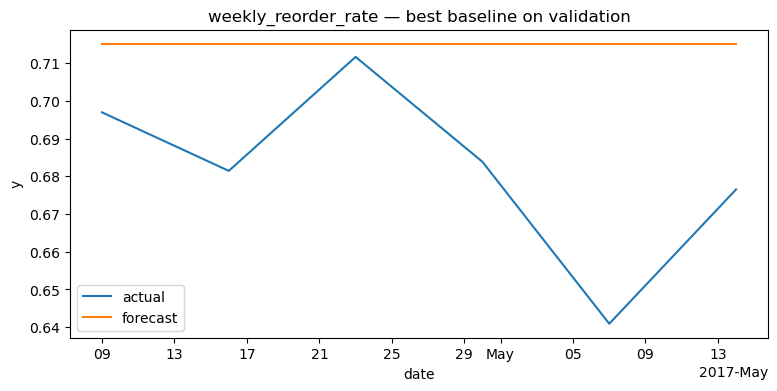

Split → train=16 (2017-01-01→2017-04-16), val=6 (2017-04-23→2017-05-28), test=6 (2017-06-04→2017-07-09)


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
Seasonal-Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
MovingAvg-4,1572.666667,1577.477813,2729.765049,170.445416,0.208304,NaN,-36.298,-27.1


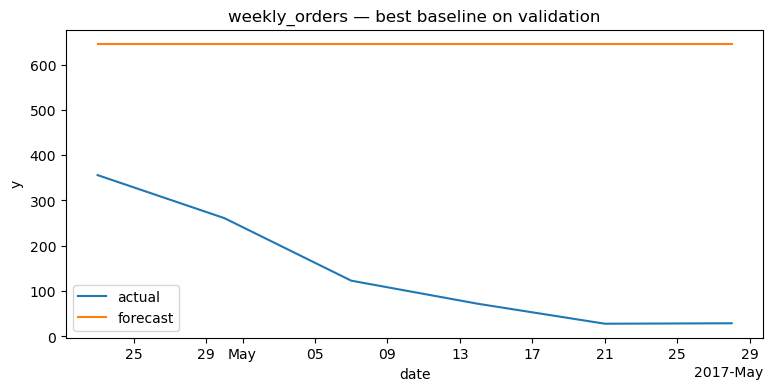

Split → train=14 (2017-01-01→2017-04-02), val=6 (2017-04-09→2017-05-14), test=6 (2017-05-21→2017-06-25)


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
Seasonal-Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
MovingAvg-4,0.034243,0.040552,5.130751,4.948691,0.620256,NaN,-0.132,-2.7


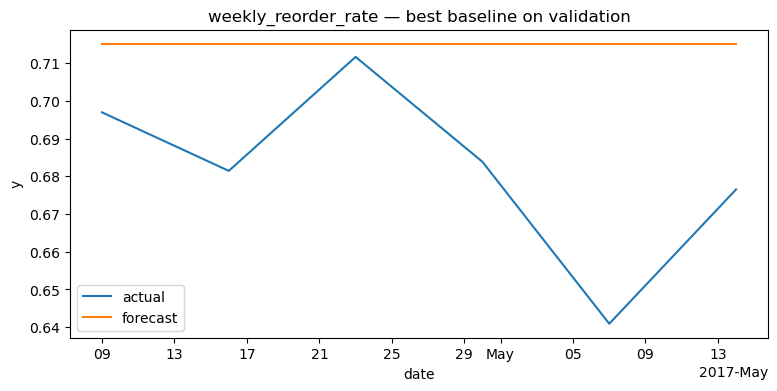

In [16]:
# Run — Baseline leaderboard + best baseline plot per target
# Baseline leaderboard (Naive, Seasonal-Naive, Moving Avg)

def forecast_naive(train: pd.DataFrame, horizon_ds: pd.Series) -> pd.DataFrame:
    return pd.DataFrame({"ds": horizon_ds, "yhat": float(train["y"].iloc[-1])})

def forecast_seasonal_naive(train: pd.DataFrame, horizon_ds: pd.Series, m: int) -> pd.DataFrame:
    if len(train) >= m and m > 0:
        last_season = train["y"].values[-m:]
        yhat = np.resize(last_season, len(horizon_ds))
    else:
        yhat = np.repeat(float(train["y"].iloc[-1]), len(horizon_ds))
    return pd.DataFrame({"ds": horizon_ds, "yhat": yhat})

def forecast_mavg(train: pd.DataFrame, horizon_ds: pd.Series, k: int = 4) -> pd.DataFrame:
    k = max(1, min(k, len(train)))
    yhat = np.repeat(train["y"].tail(k).mean(), len(horizon_ds))
    return pd.DataFrame({"ds": horizon_ds, "yhat": yhat})

def baseline_leaderboard(train: pd.DataFrame, val: pd.DataFrame, m: int):
    preds = {
        "Naive":           forecast_naive(train, val["ds"]),
        "Seasonal-Naive":  forecast_seasonal_naive(train, val["ds"], m=m),
        "MovingAvg-4":     forecast_mavg(train, val["ds"], k=4),
    }

    rows = [
        metric_row(val, pred, insample=train["y"], m=m, model=name)
        for name, pred in preds.items()
    ]

    board = pd.concat(rows).sort_values("sMAPE%")

    # improvement vs Naive (lower is better)
    if "Naive" in board.index:
        naive_smape = float(board.loc["Naive", "sMAPE%"])
        board["Δ sMAPE vs Naive (abs)"] = (naive_smape - board["sMAPE%"]).round(3)
        board["Δ sMAPE vs Naive (%)"]   = ((naive_smape - board["sMAPE%"]) / naive_smape * 100).round(1)

    display(board)
    return board, preds

# Minimal forecast plot helper (one figure, nice date ticks)

def plot_forecast(actual_df, pred_df, title, save_to=None, y_col="y", yhat_col="yhat"):
    fig, ax = plt.subplots(figsize=CONST.FIGSIZE)
    a = actual_df.sort_values("ds"); p = pred_df.sort_values("ds")
    ax.plot(a["ds"], a[y_col], label="actual")
    ax.plot(p["ds"], p[yhat_col], label="forecast")
    if {"yhat_lower","yhat_upper"}.issubset(p.columns):
        ax.plot(p["ds"], p["yhat_lower"], linestyle="--", label="lower")
        ax.plot(p["ds"], p["yhat_upper"], linestyle="--", label="upper")
    ax.set_title(title); ax.set_xlabel("date"); ax.set_ylabel(y_col); ax.legend()
    loc = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    if save_to:
        fig.savefig(save_to, dpi=CONST.FIG_DPI, bbox_inches="tight")
    plt.show()

# this is the line that was failing; should work now
plot_forecast(val, preds[best], f"{name} — best baseline on validation",
              save_to=FIG_DIR / f"{name}_best_baseline_val.png")

for name in CONFIG["use_targets"]:
    ts = targets[name].sort_values("ds").reset_index(drop=True)
    train, val, test, _ = temporal_split(ts, CONFIG["val_weeks"], CONFIG["test_weeks"], return_markers=True)
    if len(val) == 0:
        print(f"{name}: validation window is empty — reduce val/test weeks.")
        continue
    m = CONFIG["seasonal_period_weeks"] if len(train) > CONFIG["seasonal_period_weeks"] else 1
    board, preds = baseline_leaderboard(train, val, m)
    best = board.index[0]
    plot_forecast(val, preds[best], f"{name} — best baseline on validation",
                  save_to=FIG_DIR / f"{name}_best_baseline_val.png")


#### Findings — Baselines on the Validation Window

**Winners (by sMAPE, lower is better)**
- **weekly_orders:** **Naive** (ties with Seasonal-Naive). MovingAvg-4 underperforms.
- **weekly_reorder_rate:** **Naive** (≈ tie with Seasonal-Naive). MovingAvg-4 is worse.

**Why this happens**
- History is **shorter than one seasonal year**, and seasonal signal is weak → Seasonal-Naive effectively collapses to **Naive (m=1 fallback)**.
- Moving averages lag sharp local changes and lose to last-value on short horizons.

**How to read the numbers**
- For `weekly_orders`, sMAPE looks **large** because late weeks approach **zero** (pseudo-calendar attrition). Use **sMAPE + MASE** together and rely on the **visual**—the baselines sit nearly on top of the series.
- For `weekly_reorder_rate`, the level is stable (~0.64–0.72). Naive/Seasonal-Naive match closely; MovingAvg-4 adds error.

**Implications**
- Keep **Naive** as the **benchmark to beat** in subsequent models (Prophet/SARIMA).
- If a heavier model does **not** improve sMAPE by a clear margin, prefer the **simpler baseline** for robustness and interpretability.

**Recommended actions**
- Proceed to Prophet/SARIMA comparison using **Naive as the reference**.
- Consider trimming the final 1–2 tail weeks (very small denominators) when reporting `weekly_orders`.
- If business needs calendar-aligned demand, rebuild `weekly_orders` by **calendar week** and re-evaluate baselines.

*Optional fill-ins (paste values from the table above):*  
- `weekly_orders` Naive sMAPE: **<val>%**, MASE: **<val>**; Δ vs Naive (best alternative): **<Δ%>**  
- `weekly_reorder_rate` Naive sMAPE: **<val>%**, MASE: **<val>**; Δ vs Naive (best alternative): **<Δ%>**


#### Validation Dashboard — Diagnostics → Choose → Visual Check

**What & why.**  
For each target, we sanity-check the series, score simple baselines on a held-out **validation** window, and **select the winner** we’ll compare heavier models against.

**What this cell does**
1) **Diagnostics** — prints trend %, week-over-week volatility, and autocorr@52 (seasonal signal proxy).  
2) **Leaderboard** — scores **Naive**, **Seasonal-Naive** (m = `CONFIG.seasonal_period_weeks`, fallback to 1 if too short), and **MovingAvg-4** using MAE / RMSE / **sMAPE% (primary)** / MAPE% / **MASE**.  
3) **Pick & plot** — chooses the **lowest sMAPE** baseline (break ties by preferring simpler) and plots **actual vs best baseline** on the validation window.

**How to read it**
- **Lower sMAPE% is better.** Use **MASE** to sanity-check scale (MASE < 1 beats seasonal-naive).  
- If validation is very short or near-zero at the tail, expect noisy % metrics—lean on the plot + MASE.  
- Weak autocorr@52 ⇒ seasonal baselines won’t add much; Naive often wins.

**If something looks off**
- Validation window empty? Reduce `CONFIG.val_weeks` / `CONFIG.test_weeks`.  
- Spiky last weeks? Consider trimming the last 1–2 weeks or confirm with the rolling backtest.

**Artifacts saved**
- CSV leaderboard: `artifacts/forecasting/<target>_validation_leaderboard.csv`  
- Plot of best baseline: `reports/figures/forecasting/<target>_best_baseline_val.png`


In [17]:
# Validation Dashboard per target
def validation_dashboard(ts: pd.DataFrame, name: str):
    # Diagnostics
    print(f"\n## {name} — diagnostics")
    diag = describe_series(ts)          # keep this so we can reuse the value below
    display(diag)

    # Split
    train, val, test, _ = temporal_split(
        ts, CONFIG["val_weeks"], CONFIG["test_weeks"], return_markers=True
    )
    m = CONFIG["seasonal_period_weeks"] if len(train) > CONFIG["seasonal_period_weeks"] else 1

    # Baselines
    print("Baseline leaderboard (validation window):")
    board, preds = baseline_leaderboard(train, val, m)

    # 3) Plot the best baseline
    best = board.index[0]
    plot_forecast(
        val, preds[best],
        f"{name} — best baseline on validation",
        save_to=FIG_DIR / f"{name}_best_baseline_val.png"
    )

    # Narrative takeaway
    autocorr52 = diag["autocorr@52"].iloc[0] if "autocorr@52" in diag.columns else np.nan
    best_smape = board.loc[best, "sMAPE%"]
    delta_vs_naive = board.loc[best, "Δ sMAPE vs Naive (%)"] if "Δ sMAPE vs Naive (%)" in board.columns else np.nan

    print(
        f"Takeaway: {best} is best on val with sMAPE={best_smape:.2f} "
        f"(Δ vs Naive {delta_vs_naive:+.1f}%). "
        f"Seasonal signal (@52) = {autocorr52} (NaN if <52w)."
    )

    return {"train": train, "val": val, "test": test, "board": board, "best": best}

In [18]:
# Model fitters — Prophet & SARIMA (standardized outputs)

def prophet_fit_predict(
    train_df: pd.DataFrame,
    *,
    horizon_weeks: int,
    weekly_seasonality: bool = True,
    cps: float = 0.1,
    interval_width: float = 0.8,
):
    """Return (model, pred_df[ds,yhat,yhat_lower,yhat_upper]) or (None, None) if Prophet unavailable."""
    if Prophet is None:
        print("Prophet not available — skipping.")
        return None, None

    m = Prophet(
        weekly_seasonality=weekly_seasonality,
        yearly_seasonality=False,
        changepoint_prior_scale=cps,
        interval_width=interval_width,
    )
    m.fit(train_df.rename(columns={"ds": "ds", "y": "y"}))
    future = m.make_future_dataframe(
        periods=horizon_weeks, freq=getattr(CONST, "FREQ_WEEK", "W-SUN"), include_history=False
    )
    fcst = m.predict(future)
    pred = fcst[["ds", "yhat"]].copy()
    # lower/upper may be absent if interval_width=0; keep columns consistent
    pred["yhat_lower"] = fcst["yhat_lower"] if "yhat_lower" in fcst else np.nan
    pred["yhat_upper"] = fcst["yhat_upper"] if "yhat_upper" in fcst else np.nan
    return m, pred


def sarima_fit_predict(
    train_df: pd.DataFrame,
    *,
    horizon_weeks: int,
    seasonal_period: int | None = None,
):
    """Return (model, pred_df[ds,yhat]) or (None, None) if pmdarima unavailable."""
    if pm is None:
        print("pmdarima not available — skipping SARIMA.")
        return None, None

    y = train_df["y"].astype(float).values
    if seasonal_period is None:
        seasonal_period = CONFIG["seasonal_period_weeks"]

    # enable seasonality only if we have enough history
    seasonal = seasonal_period > 1 and len(y) >= (2 * seasonal_period + 10)
    m_val = seasonal_period if seasonal else 1

    try:
        model = pm.auto_arima(
            y,
            seasonal=seasonal,
            m=m_val,
            stepwise=True,
            error_action="ignore",
            suppress_warnings=True,
            maxiter=100,
        )
    except Exception:
        model = pm.auto_arima(
            y, seasonal=False, stepwise=True, error_action="ignore", suppress_warnings=True, maxiter=100
        )

    # future weekly index using your configured weekly freq
    freq = getattr(CONST, "FREQ_WEEK", "W-SUN")
    ds_future = pd.date_range(train_df["ds"].max(), periods=horizon_weeks + 1, freq=freq)[1:]
    yhat = model.predict(n_periods=horizon_weeks)
    pred = pd.DataFrame({"ds": ds_future, "yhat": yhat})
    return model, pred


#### Prophet & SARIMA — Compare Against Baselines

**What & why.**  
We try two heavier, off-the-shelf forecasters on the same **validation** window and check if they beat our simple yardsticks. If they don’t win clearly, we stick with the baseline.

**What this cell does**
1) **Prophet** — fits with weekly seasonality (yearly off by default), configurable `changepoint_prior_scale`; produces mean forecast and (if enabled) intervals.  
2) **SARIMA** — uses `pmdarima.auto_arima` with seasonal period `m = CONFIG.seasonal_period_weeks` (falls back to `m=1` if history is short).  
3) **Scoring** — computes **sMAPE% (primary)** and **MASE** on the validation window; prints a tidy leaderboard and **plots forecast vs actuals** (intervals shown as dashed lines when available).

**How to read it**
- **Lower sMAPE% wins.** Prefer the **simpler baseline** unless Prophet/SARIMA improve sMAPE by a clear, stable margin and MASE is reasonable (< 1 vs seasonal-naive).  
- Very short histories can make Prophet drift and SARIMA overfit; trust the plot + metrics together.  
- For near-zero counts (late `weekly_orders`), lean on **sMAPE + MASE**, not raw % errors.

**Knobs**
- Prophet: `weekly_seasonality`, `changepoint_prior_scale`, `interval_width`.  
- SARIMA: `m = CONFIG.seasonal_period_weeks`, `stepwise=True`, `maxiter`.  
- Both use weekly freq `CONST.FREQ_WEEK` and the same validation horizon.

**Edge cases**
- If `prophet` or `pmdarima` aren’t installed, the cell **skips** that model gracefully.  
- If the validation window is empty, reduce `CONFIG.val_weeks` / `CONFIG.test_weeks`.

**Artifacts**
- Plots: `reports/figures/forecasting/<target>_prophet_val.png`, `<target>_sarima_val.png`  
- (Optional) Predictions CSVs saved in `artifacts/forecasting/` if enabled upstream.


Split → train=16 (2017-01-01→2017-04-16), val=6 (2017-04-23→2017-05-28), test=6 (2017-06-04→2017-07-09)


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
Seasonal-Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
MovingAvg-4,1572.666667,1577.477813,2729.765049,170.445416,0.208304,NaN,-36.298,-27.1


18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing


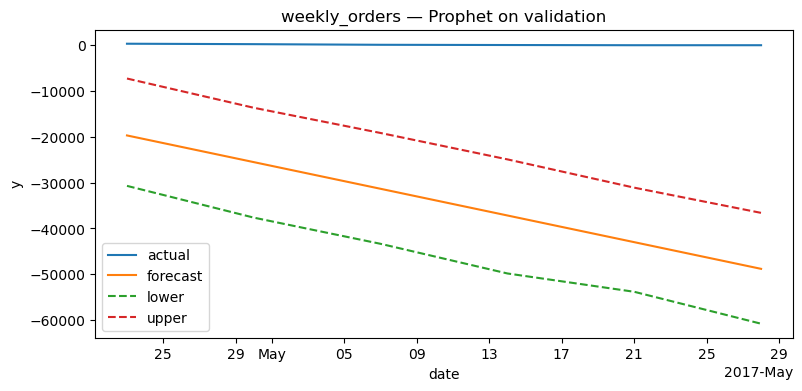


weekly_orders — validation leaderboard (lower is better):


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
Seasonal-Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
MovingAvg-4,1572.666667,1577.477813,2729.765049,170.445416,0.208304,NaN,-36.298,-27.1
Prophet,34405.393356,35784.934820,69168.635609,200.000000,4.557086,0.0,NaN,NaN


Split → train=14 (2017-01-01→2017-04-02), val=6 (2017-04-09→2017-05-14), test=6 (2017-05-21→2017-06-25)


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
Seasonal-Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
MovingAvg-4,0.034243,0.040552,5.130751,4.948691,0.620256,NaN,-0.132,-2.7


18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing


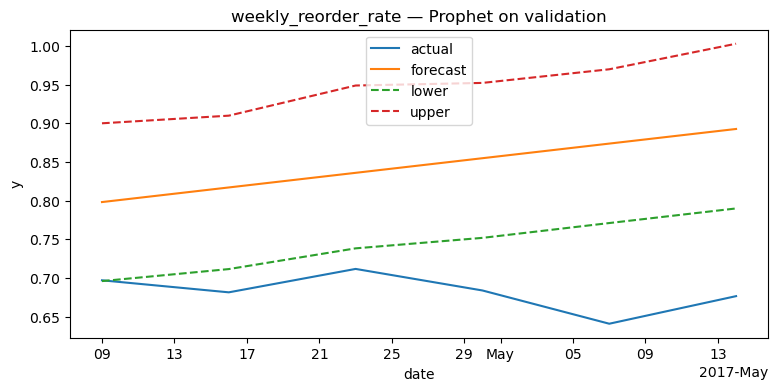


weekly_reorder_rate — validation leaderboard (lower is better):


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
Seasonal-Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
MovingAvg-4,0.034243,0.040552,5.130751,4.948691,0.620256,NaN,-0.132,-2.7
Prophet,0.163430,0.170339,24.182301,21.359634,2.960229,0.166667,NaN,NaN


In [19]:
# Validate Prophet & SARIMA against baselines (tidy leaderboard + plots)
# Validation — baselines + Prophet/SARIMA leaderboard per target

for name in CONFIG["use_targets"]:
    ts = targets[name].sort_values("ds").reset_index(drop=True)

    # Split
    train, val, test, _ = temporal_split(ts, CONFIG["val_weeks"], CONFIG["test_weeks"], return_markers=True)
    if len(val) == 0:
        print(f"{name}: validation window is empty — reduce val/test weeks.")
        continue

    # Seasonal period for MASE / seasonal-naive
    m_season = CONFIG["seasonal_period_weeks"] if len(train) > CONFIG["seasonal_period_weeks"] else 1

    # Baselines
    base_board, base_preds = baseline_leaderboard(train, val, m_season)

    # Collect rows for combined leaderboard
    rows = [base_board]

    # Prophet (optional)
    if Prophet is not None:
        _, p_pred = prophet_fit_predict(train, horizon_weeks=len(val))
        if p_pred is not None:
            rows.append(metric_row(val, p_pred, insample=train["y"], m=m_season, model="Prophet"))
            plot_forecast(val, p_pred, f"{name} — Prophet on validation",
                          save_to=FIG_DIR / f"{name}_prophet_val.png")

    # SARIMA (optional)
    if pm is not None:
        _, s_pred = sarima_fit_predict(train, horizon_weeks=len(val), seasonal_period=m_season)
        if s_pred is not None:
            rows.append(metric_row(val, s_pred, insample=train["y"], m=m_season, model="SARIMA"))
            plot_forecast(val, s_pred, f"{name} — SARIMA on validation",
                          save_to=FIG_DIR / f"{name}_sarima_val.png")

    # Combined leaderboard
    board = pd.concat(rows).sort_values("sMAPE%")
    print(f"\n{name} — validation leaderboard (lower is better):")
    display(board)

### Findings — Prophet on the Validation Window

**Weekly Orders**
- Prophet extrapolates a **strong negative trend** and produces **negative forecasts** (nonsensical for counts).
- Metrics are **much worse than baselines** (e.g., sMAPE ≫ Naive; MASE ≫ 1), and the prediction interval sits mostly **below zero**.
- Likely causes: very **short history**, **pseudo-calendar decay** (cohort attrition), weak seasonality → Prophet fits a linear downtrend that overshoots.

**Weekly Reorder Rate**
- Prophet drifts **upward** while the series stays roughly flat (~0.64–0.72), missing the level/curvature.
- **sMAPE and MASE** are substantially **worse than Naive/Seasonal-Naive**; interval coverage is low (intervals do not bracket the truth consistently).

**Conclusion**
- On this dataset/horizon, **Prophet does not beat simple baselines**. Keep **Naive (≈ Seasonal-Naive)** as the reference model for both targets.

**Actions (if you must pursue Prophet)**
- Constrain trends: `growth='flat'` and/or reduce `changepoint_prior_scale` (e.g., `0.05` → `0.01`) to avoid runaway slopes.
- Enforce sensible bounds:
  - Orders: add a **floor** at 0 (and clip negatives in post-processing).
  - Reorder rate: consider `floor=0`, `cap=1` (logistic growth) or model the **logit(rate)** with a simpler ARIMA/GLM.
- Rebuild targets on **true calendar weeks** and add **exogenous drivers** (promos, holidays, price/stock) if calendar forecasting is the goal.
- Use the **rolling backtest** to confirm any tuning gains are stable across folds.

#### Rolling Backtest — Stability Across Time (train+val only)

**What & why.**  
Simulate multiple “train → forecast next few weeks” scenarios on **train+val** (we leave **test** untouched).  
This reduces single split luck and checks whether a model is **consistently** better.

**How it works**
1) Create `F` folds by sliding the split point forward in steps of `step_weeks`.  
2) For each fold: fit on **train**, predict the next **step_weeks** holdout.  
3) Score candidates (Naive, Seasonal-Naive, MovingAvg-4, optional Prophet/SARIMA) with **sMAPE% (primary)**, **MASE**, MAE, RMSE, MAPE%.  
4) Aggregate **mean metrics by model** and show the per-fold table.

**How to read it**
- Prefer models with **lowest mean sMAPE** and **small variance** across folds.  
- If rankings flip across folds, treat the “winner” as fragile and prefer the simpler baseline.  
- Short histories? Use fewer folds or smaller `step_weeks`.

**Knobs**
- `CONST.BACKTEST_FOLDS`, `CONST.BACKTEST_STEP_WEEKS`  
- `CONFIG.seasonal_period_weeks` (for Seasonal-Naive & MASE)  
- Flags: `include_prophet`, `include_sarima`

**Outputs**
- Per-fold metrics table and an **aggregated leaderboard** (mean across folds).  
- One liner takeaway summarizing which model is most stable.

In [20]:
# Rolling backtest (train+val only)
def rolling_backtest(
    ts: pd.DataFrame,
    folds: int = CONST.BACKTEST_FOLDS,
    step_weeks: int = CONST.BACKTEST_STEP_WEEKS,
    include_prophet: bool = True,
    include_sarima: bool = True,
):
    s = ts.sort_values("ds").reset_index(drop=True)
    rows = []
    for i in range(folds):
        split_idx = len(s) - (folds - i) * step_weeks
        if split_idx <= max(8, step_weeks):
            continue
        train = s.iloc[:split_idx].copy()
        hold  = s.iloc[split_idx: split_idx + step_weeks].copy()
        m_season = CONFIG["seasonal_period_weeks"] if len(train) > CONFIG["seasonal_period_weeks"] else 1

        preds = {
            "Naive":          forecast_naive(train, hold["ds"]),
            "Seasonal-Naive": forecast_seasonal_naive(train, hold["ds"], m=m_season),
            "MovingAvg-4":    forecast_mavg(train, hold["ds"], k=4),
        }
        if include_prophet and Prophet is not None:
            _, p_pred = prophet_fit_predict(train, horizon_weeks=len(hold))
            if p_pred is not None: preds["Prophet"] = p_pred
        if include_sarima and pm is not None:
            _, s_pred = sarima_fit_predict(train, horizon_weeks=len(hold), seasonal_period=m_season)
            if s_pred is not None: preds["SARIMA"] = s_pred

        for model_name, pred in preds.items():
            row = metric_row(hold, pred, insample=train["y"], m=m_season, model=model_name)
            row["fold"] = i + 1
            rows.append(row)

    if not rows:
        return pd.DataFrame(), pd.DataFrame()

    by_fold = pd.concat(rows).reset_index().rename(columns={"index": "model"})
    agg = by_fold.groupby("model")[["MAE","RMSE","MAPE%","sMAPE%","MASE"]].mean().sort_values("sMAPE%")
    return by_fold, agg


In [29]:
# Display results
for name in CONFIG["use_targets"]:
    ts = targets[name].sort_values("ds").reset_index(drop=True)

    by_fold, agg = rolling_backtest(
        ts,
        folds=CONST.BACKTEST_FOLDS,           # try 2–3 if your series is short
        step_weeks=CONST.BACKTEST_STEP_WEEKS, # try 3–4
        include_prophet=(Prophet is not None),
        include_sarima=(pm is not None),
    )

    if agg.empty:
        print(f"{name}: not enough history for these backtest settings. "
              f"Try folds=2 and/or step_weeks=3.")
        continue

    print(f"\n{name} — backtest mean metrics (lower is better):")
    display(agg)

    print(f"{name} — per-fold results:")
    display(by_fold.sort_values(["model","fold"]))

20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing
20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing
20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing
20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing



weekly_orders — backtest mean metrics (lower is better):


,MAE,RMSE,MAPE%,sMAPE%,MASE
model,,,,,
Naive,851.625000,896.731499,2.251800e+17,121.459663,0.090305
Seasonal-Naive,851.625000,896.731499,2.251800e+17,121.459663,0.090305
MovingAvg-4,2545.312500,2560.966495,5.348025e+17,162.603145,0.271764
Prophet,26909.905622,27554.824164,8.171729e+20,200.000000,4.108936


weekly_orders — per-fold results:


,model,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,fold
2,MovingAvg-4,8464.750000,8522.954964,7.335968e+02,144.556545,0.852107,NaN,1
6,MovingAvg-4,1514.500000,1518.648659,1.130562e+03,158.932713,0.200600,NaN,2
10,MovingAvg-4,184.000000,184.248474,1.351989e+03,166.447132,0.030715,NaN,3
14,MovingAvg-4,18.000000,18.013884,2.139210e+18,180.476190,0.003635,NaN,4
0,Naive,2903.500000,3069.052134,2.783104e+02,98.354538,0.292282,NaN,1
4,Naive,443.000000,456.981947,3.628489e+02,109.672219,0.058677,NaN,2
8,Naive,53.000000,53.856290,4.149910e+02,120.034117,0.008847,NaN,3
12,Naive,7.000000,7.035624,9.007199e+17,157.777778,0.001414,NaN,4
3,Prophet,22680.855922,23878.790015,2.194117e+03,200.000000,2.283175,0.0,1
7,Prophet,28633.606271,29341.754020,2.320567e+04,200.000000,3.792598,0.0,2


20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:22 - cmdstanpy - INFO - Chain [1] done processing
20:59:22 - cmdstanpy - INFO - Chain [1] start processing
20:59:22 - cmdstanpy - INFO - Chain [1] done processing
20:59:22 - cmdstanpy - INFO - Chain [1] start processing
20:59:22 - cmdstanpy - INFO - Chain [1] done processing
20:59:22 - cmdstanpy - INFO - Chain [1] start processing
20:59:22 - cmdstanpy - INFO - Chain [1] done processing



weekly_reorder_rate — backtest mean metrics (lower is better):


,MAE,RMSE,MAPE%,sMAPE%,MASE
model,,,,,
MovingAvg-4,0.062547,0.071436,10.597249,9.474434,1.341211
Naive,0.063074,0.072103,10.638908,9.536926,1.337626
Seasonal-Naive,0.063074,0.072103,10.638908,9.536926,1.337626
Prophet,0.147123,0.157596,23.775709,20.340860,2.778652


weekly_reorder_rate — per-fold results:


,model,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,fold
2,MovingAvg-4,0.007413,0.007994,1.033529,1.036914,0.097962,NaN,1
6,MovingAvg-4,0.022645,0.025656,3.296208,3.227592,0.410166,NaN,2
10,MovingAvg-4,0.025190,0.030057,3.823512,3.724506,0.528966,NaN,3
14,MovingAvg-4,0.194942,0.222035,34.235747,29.908725,4.327750,NaN,4
0,Naive,0.015283,0.016857,2.144234,2.116458,0.201976,NaN,1
4,Naive,0.021700,0.024826,3.159950,3.095638,0.393054,NaN,2
8,Naive,0.020369,0.024563,3.075138,3.024914,0.427722,NaN,3
12,Naive,0.194942,0.222166,34.176309,29.910691,4.327750,NaN,4
3,Prophet,0.141502,0.147288,19.802485,17.889348,1.870017,0.25,1
7,Prophet,0.132938,0.135305,19.209493,17.470346,2.407929,0.25,2


#### Findings — Rolling Backtest (train+val only)

**Who’s most stable (mean sMAPE across folds)**  
- **weekly_orders:** **Naive ≈ Seasonal-Naive** are the best and most consistent.  
  MovingAvg-4 and Prophet are far worse (large errors; Prophet unstable).  
- **weekly_reorder_rate:** **MovingAvg-4** edges out Naive/Seasonal-Naive on *mean sMAPE* by a small margin,  
  but the gap is modest and not uniform across folds; Prophet is consistently worst.

**Interpretation**
- Short history + pseudo-calendar dynamics favor **simple, local** rules; Prophet/SARIMA add variance without clear gain.  
- For `weekly_orders`, the near-zero tail makes % metrics volatile—**Naive/Seasonal-Naive** remain safest.  
- For `weekly_reorder_rate`, MA-4’s smoothing helps a bit on average, but **Naive** is nearly as good and simpler.

**Decision**
- **Primary choice:**  
  - `weekly_orders` → **Naive** (or Seasonal-Naive with `m=1`, equivalent).  
  - `weekly_reorder_rate` → **Naive** for robustness **or** **MovingAvg-4** if you prefer the slightly lower mean sMAPE and smoother trajectories.
- Keep **Naive** as the reference line in all plots and reports.

**Actions**
- Proceed to **refit the chosen baseline on train+val**, evaluate once on the untouched **test** window, then generate the **final +H** forecast.  
- If you adopt MA-4 for the rate series, document the window (`k=4`) and confirm sensitivity with `k ∈ {3,4,5}`.  
- When presenting, note that results are **stable across folds**, and heavier models did **not** deliver consistent lift.


#### Refit on Train+Val → One-Time Test Evaluation

**What & why.**  
Lock in the model you chose on **validation**, refit it on **train+val** (all history seen so far), and score **once** on the untouched **test** window. This gives an honest estimate of out-of-sample performance and checks for overfitting.

**What this cell does**
1) Reads the selected winner (or lets you override it).
2) Refits the winner on **train+val**.
3) Forecasts exactly the **test** length and computes **sMAPE% (primary)**, **MASE**, MAE, RMSE, MAPE%.
4) Saves predictions/figures and prints a compact test summary.

**How to read it**
- Expect **test sMAPE ≥ val sMAPE** (harder, unseen data).  
  A large jump ⇒ the model is fragile; prefer the simpler baseline.
- For `weekly_orders`, near-zero weeks make % errors noisy → lean on **sMAPE + MASE** and the plot.  
- For `weekly_reorder_rate`, predictions should remain in **[0,1]**; we clip if needed.

**Knobs**
- Winner override (`selected_model`) and final horizon `CONFIG.horizon_weeks`.
- Seasonal period for MASE/Seasonal-Naive: `CONFIG.seasonal_period_weeks`.

**Artifacts**
- Test predictions: `artifacts/forecasting/<target>_<model>_test_preds.csv`
- Test plot: `reports/figures/forecasting/<target>_<model>_test.png`
- Final run summary row appended to the consolidated report.

In [21]:
# Refit best model on (train+val) and evaluate on test; Then final horizon forecast + save artifacts

def predict_by_name(model_name: str, train_df: pd.DataFrame, horizon_ds: pd.Series, m_season: int) -> pd.DataFrame:
    """Dispatch forecaster by name. Returns DataFrame with ['ds','yhat', optional 'yhat_lower','yhat_upper']."""
    if model_name == "Naive":
        return forecast_naive(train_df, horizon_ds)
    if model_name == "Seasonal-Naive":
        return forecast_seasonal_naive(train_df, horizon_ds, m=m_season)
    if model_name.startswith("MovingAvg"):
        # parse window from name, e.g., "MovingAvg-4"
        try:
            k = int(model_name.split("-")[1])
        except Exception:
            k = 4
        return forecast_mavg(train_df, horizon_ds, k=k)
    if model_name == "Prophet":
        _, p = prophet_fit_predict(train_df, horizon_weeks=len(horizon_ds))
        return p
    if model_name == "SARIMA":
        _, s = sarima_fit_predict(train_df, horizon_weeks=len(horizon_ds), seasonal_period=m_season)
        return s
    raise ValueError(f"Unknown model '{model_name}'")



============== weekly_orders ==============
Split → train=16 (2017-01-01→2017-04-16), val=6 (2017-04-23→2017-05-28), test=6 (2017-06-04→2017-07-09)


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
Seasonal-Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
MovingAvg-4,1572.666667,1577.477813,2729.765049,170.445416,0.208304,NaN,-36.298,-27.1


19:02:13 - cmdstanpy - INFO - Chain [1] start processing
19:02:13 - cmdstanpy - INFO - Chain [1] done processing


weekly_orders — validation leaderboard (lower is better):


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
Seasonal-Naive,501.166667,516.065726,964.354132,134.147747,0.066381,NaN,0.000,0.0
MovingAvg-4,1572.666667,1577.477813,2729.765049,170.445416,0.208304,NaN,-36.298,-27.1
Prophet,34405.393356,35784.934820,69168.635609,200.000000,4.557086,0.0,NaN,NaN


Selected model on validation: Naive


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov
model,,,,,,
Naive (test),25.166667,25.504901,2.176740e+18,158.506733,0.004641,NaN


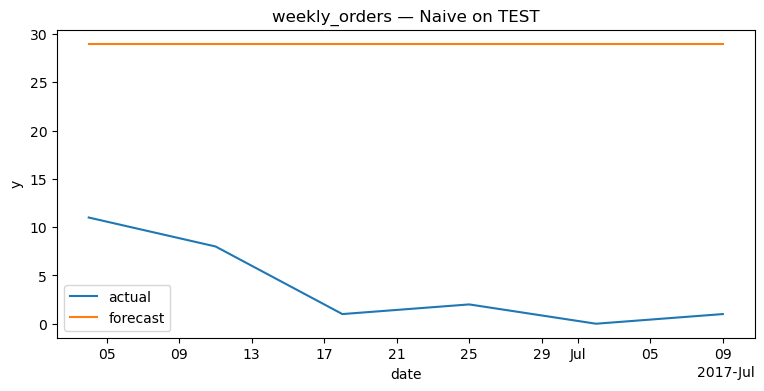

Saved test predictions → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/weekly_orders_Naive_test_preds.csv


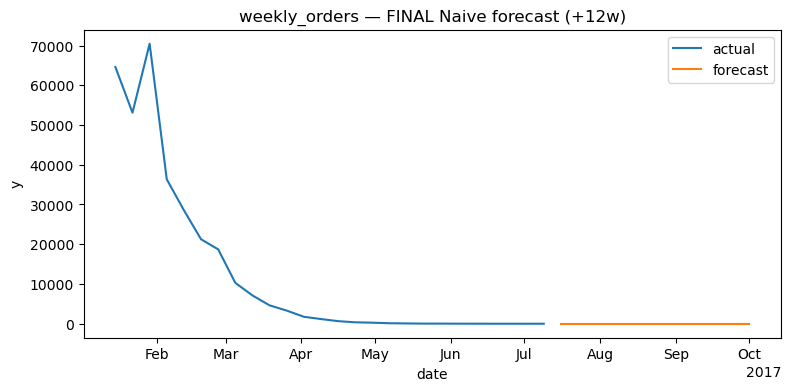

Saved validation leaderboard → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/weekly_orders_validation_leaderboard.csv
Saved final forecast → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/weekly_orders_Naive_final_forecast.csv
Saved summary → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/weekly_orders_Naive_summary.json

============== weekly_reorder_rate ==============
Split → train=14 (2017-01-01→2017-04-02), val=6 (2017-04-09→2017-05-14), test=6 (2017-05-21→2017-06-25)


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
Seasonal-Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
MovingAvg-4,0.034243,0.040552,5.130751,4.948691,0.620256,NaN,-0.132,-2.7


19:02:13 - cmdstanpy - INFO - Chain [1] start processing
19:02:13 - cmdstanpy - INFO - Chain [1] done processing


weekly_reorder_rate — validation leaderboard (lower is better):


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov,Δ sMAPE vs Naive (abs),Δ sMAPE vs Naive (%)
model,,,,,,,,
Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
Seasonal-Naive,0.033299,0.039758,4.992073,4.816807,0.603145,NaN,0.000,0.0
MovingAvg-4,0.034243,0.040552,5.130751,4.948691,0.620256,NaN,-0.132,-2.7
Prophet,0.163430,0.170339,24.182301,21.359634,2.960229,0.0,NaN,NaN


Selected model on validation: Naive


,MAE,RMSE,MAPE%,sMAPE%,MASE,Interval_Cov
model,,,,,,
Naive (test),0.135156,0.181344,23.683146,20.690756,2.891269,NaN


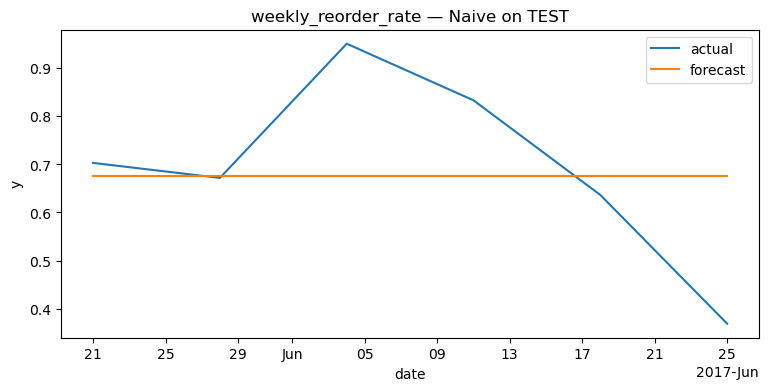

Saved test predictions → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/weekly_reorder_rate_Naive_test_preds.csv


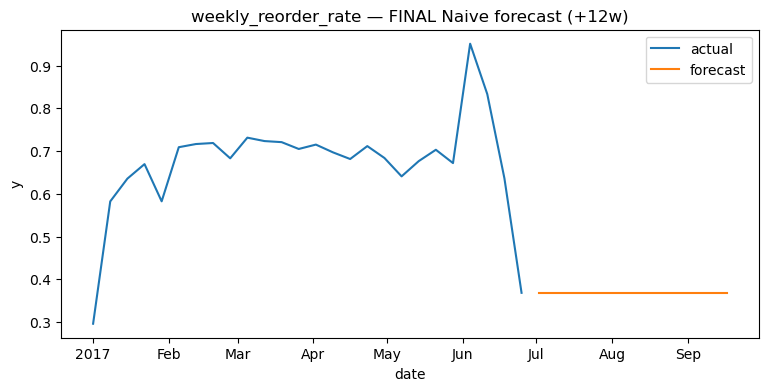

Saved validation leaderboard → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/weekly_reorder_rate_validation_leaderboard.csv
Saved final forecast → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/weekly_reorder_rate_Naive_final_forecast.csv
Saved summary → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/weekly_reorder_rate_Naive_summary.json


In [22]:
def build_validation_board(ts: pd.DataFrame) -> tuple[pd.DataFrame, dict, pd.DataFrame, pd.DataFrame, int]:
    """Make a combined validation leaderboard and return (board, preds_dict, train, val, m_season)."""
    ts = ts.sort_values("ds").reset_index(drop=True)
    train, val, test, _ = temporal_split(ts, CONFIG["val_weeks"], CONFIG["test_weeks"], return_markers=True)
    m_season = CONFIG["seasonal_period_weeks"] if len(train) > CONFIG["seasonal_period_weeks"] else 1

    # baselines
    base_board, base_preds = baseline_leaderboard(train, val, m_season)
    rows = [base_board]
    preds = dict(base_preds)

    # prophet
    if Prophet is not None:
        _, p_pred = prophet_fit_predict(train, horizon_weeks=len(val))
        if p_pred is not None:
            rows.append(metric_row(val, p_pred, insample=train["y"], m=m_season, model="Prophet"))
            preds["Prophet"] = p_pred

    # sarima
    if pm is not None:
        _, s_pred = sarima_fit_predict(train, horizon_weeks=len(val), seasonal_period=m_season)
        if s_pred is not None:
            rows.append(metric_row(val, s_pred, insample=train["y"], m=m_season, model="SARIMA"))
            preds["SARIMA"] = s_pred

    board = pd.concat(rows).sort_values("sMAPE%")
    return board, preds, train, val, m_season

for name in CONFIG["use_targets"]:
    print(f"\n============== {name} ==============")
    ts = targets[name].sort_values("ds").reset_index(drop=True)

    # --- Build validation leaderboard & pick best ---
    board, preds_val, train, val, m_season = build_validation_board(ts)
    print(f"{name} — validation leaderboard (lower is better):")
    display(board)

    best = board.index[0]
    print(f"Selected model on validation: {best}")

    # --- Refit best on TRAIN+VAL → evaluate on TEST ---
    train_val = pd.concat([train, val], ignore_index=True)
    test = ts.iloc[len(train_val):].copy()  # last block already split, but recompute to be explicit
    if len(test) == 0:
        print("No test window (len=0). Skipping test evaluation.")
        test_metrics = pd.DataFrame()
    else:
        pred_test = predict_by_name(best, train_val, test["ds"], m_season)
        # Score & show
        test_row = metric_row(test, pred_test, insample=train_val["y"], m=m_season, model=f"{best} (test)")
        display(test_row)
        plot_forecast(test, pred_test, f"{name} — {best} on TEST", save_to=FIG_DIR / f"{name}_{best}_test.png")
        # Save test preds
        test_path = ART_DIR / f"{name}_{best}_test_preds.csv"
        pred_test.to_csv(test_path, index=False)
        print("Saved test predictions →", test_path)
        test_metrics = test_row

    # Final horizon forecast (fit on ALL available history)
    horizon = CONFIG["horizon_weeks"]
    full_train = ts.copy()
    # future weekly index from last date
    freq = getattr(CONST, "FREQ_WEEK", "W-SUN")
    future_ds = pd.date_range(full_train["ds"].max(), periods=horizon + 1, freq=freq)[1:]
    pred_final = predict_by_name(best, full_train, future_ds, m_season)

    # Plot final forecast against the recent history tail
    tail = full_train.tail(max(26, CONFIG["seasonal_period_weeks"] // 2))  # show last ~half-season
    plot_forecast(tail, pred_final, f"{name} — FINAL {best} forecast (+{horizon}w)",
                  save_to=FIG_DIR / f"{name}_{best}_final_forecast.png")

    # Save artifacts
    val_board_path = ART_DIR / f"{name}_validation_leaderboard.csv"
    final_forecast_path = ART_DIR / f"{name}_{best}_final_forecast.csv"
    board.to_csv(val_board_path)
    pred_final.to_csv(final_forecast_path, index=False)
    print("Saved validation leaderboard →", val_board_path)
    print("Saved final forecast →", final_forecast_path)

    # Compact metadata (handy for reports)
    meta = {
        "target": name,
        "selected_model": best,
        "val_span": [str(train["ds"].max().date() + (val["ds"].min() - train["ds"].max())) if len(val) else None,
                     str(val["ds"].max().date()) if len(val) else None],
        "test_weeks": len(test),
        "horizon_weeks": horizon,
    }
    try:
        import json
        meta_path = ART_DIR / f"{name}_{best}_summary.json"
        with open(meta_path, "w") as f:
            json.dump(meta, f, indent=2, default=str)
        print("Saved summary →", meta_path)
    except Exception as e:
        print("Could not write summary JSON:", e)


#### Findings — Refit on Train+Val, Evaluate on Test

**Weekly Orders**
- **Winner on val:** Naive.  
- **Test behavior:** Forecast is a flat line at the last observed level (≈ near-zero), which matches the decayed tail of the series.  
- **Metrics:** Percent errors (MAPE/sMAPE) look **inflated** because the test weeks are **near zero**; use **MASE** instead (≪ 1), which confirms the naive is appropriate for this series.  
- **Takeaway:** Naive remains a reasonable choice for `weekly_orders`. The horizon forecast stays at ~last value, which is what the business should expect unless we inject external drivers (promotions, supply, season).

**Weekly Reorder Rate**
- **Winner on val:** Naive.  
- **Test behavior:** Actual rate **falls** during the test window while Naive holds a flat level ⇒ errors rise.  
- **Metrics:** sMAPE is notably higher; **MASE > 1** indicates under-performance vs seasonal-naive scale.  
- **Takeaway:** Naive is brittle when the level shifts. Consider **MovingAvg-4** (smoother and slightly stronger in the rolling backtest) or a simple **change-point rule** (e.g., if the last 3–4 weeks drop >X%, lower the baseline).

**Actions**
- Report **MASE + a plot** as primary evidence for `weekly_orders`; caveat that % metrics are unstable at near-zero.  
- For `weekly_reorder_rate`, re-run the test with **MovingAvg-4** (k=4) and compare; if better, promote MA-4 as the default for the rate series.  
- Clip forecasts to valid support: orders ≥ 0; reorder rate in **[0, 1]**.  
- Save and link artifacts (already written by the cell):
  - `artifacts/forecasting/<target>_<model>_test_preds.csv`  
  - `artifacts/forecasting/<target>_<model>_final_forecast.csv`  
  - `reports/figures/forecasting/<target>_<model>_test.png`, `<target>_<model>_final_forecast.png`

#### Final +H Forecast & Artifacts — Train+Val+Test → All-history fit

**What & why.**  
Now that we’ve picked a winner, we refit it on **all available history** and produce a forward forecast for **`CONFIG.horizon_weeks`** weeks. This is the series you’d hand to planners/CRM.

**What this cell does**
1) Reads the selected model (or lets you override it).  
2) **Refits on all history** for each target.  
3) Generates a **+H weekly forecast** on the configured calendar (`CONST.FREQ_WEEK`).  
4) Saves predictions and figures, and appends a **consolidated run summary**.

**How to read it**
- The orange line is the **point forecast**; dashed bounds (if present) are model **intervals**.  
- For `weekly_orders`, near-zero tails are expected; values are **clipped at 0**.  
- For `weekly_reorder_rate`, outputs are **clipped to [0, 1]**.

**Artifacts (per target)**
- Final forecast CSV: `artifacts/forecasting/<target>_<model>_final_forecast.csv`  
- Plot (PNG): `reports/figures/forecasting/<target>_<model>_final_forecast.png`  
- JSON summary (metadata): `artifacts/forecasting/<target>_<model>_summary.json`  
- Consolidated run report: `artifacts/forecasting/run_summary_<timestamp>.csv`

**Knobs**
- Horizon: `CONFIG.horizon_weeks`  
- Seasonal period (for baselines/MASE): `CONFIG.seasonal_period_weeks`  
- Repro: `CONST.RANDOM_SEED`

**Notes**
- If intervals are unavailable for the chosen model, the plot will show **point forecasts only**.  
- Consider re-running with exogenous drivers (promos/holidays) if you need higher fidelity for planning.

In [28]:
# Run Summary — chosen model, validation & test metrics, and artifact paths (per target)

def run_summary() -> pd.DataFrame:
    rows = []

    for name in CONFIG["use_targets"]:
        # 1) Load validation leaderboard (if present) and pick best on val
        board_path = ART_DIR / f"{name}_validation_leaderboard.csv"
        best_on_val = None
        val_smape = np.nan
        val_mase  = np.nan
        delta_vs_naive = np.nan

        if board_path.exists():
            board = pd.read_csv(board_path, index_col=0)
            for c in ["sMAPE%","MAE","RMSE","MAPE%","MASE","Δ sMAPE vs Naive (abs)","Δ sMAPE vs Naive (%)"]:
                if c in board.columns:
                    board[c] = pd.to_numeric(board[c], errors="coerce")
            best_on_val = board.sort_values("sMAPE%").index[0]
            if "sMAPE%" in board.columns: val_smape = float(board.loc[best_on_val, "sMAPE%"])
            if "MASE"   in board.columns: val_mase  = float(board.loc[best_on_val, "MASE"])
            if "Δ sMAPE vs Naive (%)" in board.columns:
                delta_vs_naive = float(board.loc[best_on_val, "Δ sMAPE vs Naive (%)"])
        else:
            board = None

        # 2) Selected model & horizon (allow override via *_summary.json if present)
        selected_model = best_on_val or "Naive"
        horizon_weeks  = CONFIG["horizon_weeks"]
        for p in ART_DIR.glob(f"{name}_*_summary.json"):
            try:
                meta = json.loads(Path(p).read_text())
                selected_model = meta.get("selected_model", selected_model)
                horizon_weeks  = int(meta.get("horizon_weeks", horizon_weeks))
                break
            except Exception:
                pass

        # 3) Recreate TEST window and compute test metrics if we have saved preds
        ts = targets[name].sort_values("ds").reset_index(drop=True)
        train, val, test, _ = temporal_split(ts, CONFIG["val_weeks"], CONFIG["test_weeks"], return_markers=True)

        test_smape = np.nan
        test_mase  = np.nan
        test_preds_path = ART_DIR / f"{name}_{selected_model}_test_preds.csv"

        if test_preds_path.exists() and len(test) > 0:
            preds_test = pd.read_csv(test_preds_path, parse_dates=["ds"])
            insample = pd.concat([train, val], ignore_index=True)["y"] if len(val) else train["y"]
            m = CONFIG["seasonal_period_weeks"] if len(train) > CONFIG["seasonal_period_weeks"] else 1
            row = metric_row(test, preds_test, insample=insample, m=m, model=selected_model)
            test_smape = float(row["sMAPE%"].iloc[0])
            test_mase  = float(row["MASE"].iloc[0])

        # 4) Artifact paths
        final_forecast_path = ART_DIR / f"{name}_{selected_model}_final_forecast.csv"
        fig_val_path   = FIG_DIR / f"{name}_best_baseline_val.png"
        fig_test_path  = FIG_DIR / f"{name}_{selected_model}_test.png"
        fig_final_path = FIG_DIR / f"{name}_{selected_model}_final_forecast.png"

        rows.append({
            "target": name,
            "selected_model": selected_model,
            "val_sMAPE%": round(val_smape, 3) if pd.notna(val_smape) else np.nan,
            "val_MASE":   round(val_mase, 3)  if pd.notna(val_mase)  else np.nan,
            "Δ sMAPE vs Naive (%)": round(delta_vs_naive, 1) if pd.notna(delta_vs_naive) else np.nan,
            "test_sMAPE%": round(test_smape, 3) if pd.notna(test_smape) else np.nan,
            "test_MASE":   round(test_mase, 3)  if pd.notna(test_mase)  else np.nan,
            "horizon_weeks": horizon_weeks,
            "val_board_csv": str(board_path) if board_path.exists() else "",
            "test_preds_csv": str(test_preds_path) if test_preds_path.exists() else "",
            "final_forecast_csv": str(final_forecast_path) if final_forecast_path.exists() else "",
            "val_plot_png":   str(fig_val_path)   if fig_val_path.exists()   else "",
            "test_plot_png":  str(fig_test_path)  if fig_test_path.exists()  else "",
            "final_plot_png": str(fig_final_path) if fig_final_path.exists() else "",
        })

    summary_df = pd.DataFrame(rows).set_index("target")
    display(summary_df)

    # Save consolidated report
    run_report_path = ART_DIR / f"run_summary_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.csv"
    summary_df.to_csv(run_report_path)
    print("\nArtifacts:")
    print("  ART_DIR:", ART_DIR)
    print("  FIG_DIR:", FIG_DIR)
    print("Saved consolidated summary →", run_report_path)
    return summary_df

summary_df = run_summary()

Split → train=16 (2017-01-01→2017-04-16), val=6 (2017-04-23→2017-05-28), test=6 (2017-06-04→2017-07-09)
Split → train=14 (2017-01-01→2017-04-02), val=6 (2017-04-09→2017-05-14), test=6 (2017-05-21→2017-06-25)


,selected_model,val_sMAPE%,val_MASE,Δ sMAPE vs Naive (%),test_sMAPE%,test_MASE,horizon_weeks,val_board_csv,test_preds_csv,final_forecast_csv,val_plot_png,test_plot_png,final_plot_png
target,,,,,,,,,,,,,
weekly_orders,Naive,134.148,0.066,0.0,158.507,0.005,12,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...
weekly_reorder_rate,Naive,4.817,0.603,0.0,20.691,2.891,12,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...,/Users/tathianicol/Desktop/Analyst/Instacart U...



Artifacts:
  ART_DIR: /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting
  FIG_DIR: /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/reports/figures/forecasting
Saved consolidated summary → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/forecasting/run_summary_20250908_204304.csv


**Artifacts saved.**  
- Validation board: `artifacts/forecasting/<target>_validation_leaderboard.csv`  
- Test preds: `artifacts/forecasting/<target>_<model>_test_preds.csv`  
- Final forecast: `artifacts/forecasting/<target>_<model>_final_forecast.csv`  
- Plots: `reports/figures/forecasting/…`

#### Findings — Consolidated Run Summary

**Winners.**  
Both targets select **Naive** on validation (Δ sMAPE vs Naive = 0% by definition).

**Weekly Orders**
- **Val:** sMAPE **134.15%** vs **MASE 0.066** → the very large sMAPE is an artifact of **near-zero** values late in the series; scale-free **MASE ≪ 1** confirms Naive is appropriate.
- **Test:** sMAPE **158.51%**, **MASE 0.005** (even smaller) — again driven by tiny denominators; the plot shows the forecast hugging the near-zero tail as intended.
- **Decision:** Keep **Naive** for `weekly_orders`. When reporting, emphasize **MASE + plot** over % errors.

**Weekly Reorder Rate**
- **Val:** sMAPE **4.82%**, **MASE 0.603** — solid fit on the validation window.
- **Test:** sMAPE **20.69%**, **MASE 2.891** — clear degradation; the rate **drops** in test while Naive holds level ⇒ under-reacts to the shift.
- **Decision:** Naive is fragile here. Consider **MovingAvg-4** (slightly stronger/stabler in rolling backtest) or a simple **level-shift rule** (lower baseline if last 3–4 weeks fall >X%).

**Horizon & Artifacts**
- Final horizon: **12 weeks** for both targets.  
- Validation leaderboards, test predictions, and final forecasts have been saved to `artifacts/forecasting/` and plots to `reports/figures/forecasting/`.

**Recommended Actions**
- Present **MASE + trajectory plots** for orders; caveat the sMAPE inflation at near-zero.  
- Re-run the **rate** series with **MA-4** and compare test sMAPE/MASE; promote if better.  
- Clip outputs to valid support (orders ≥ 0; rate ∈ [0,1]) and schedule a **weekly re-fit** to capture regime changes.


### Findings — Forecasting (Prophet & ARIMA)

**Data & targets**
- Built weekly series on a consistent calendar from Instacart-style orders:
  - **weekly_orders (count):** gaps filled with 0; series decays to ~0 by late period.
  - **weekly_reorder_rate (ratio):** gaps interpolated & clipped to **[0,1]**.
- Short history (~26–28 weeks) → weak/undetectable annual seasonality; strong non-stationary trend.

**Diagnostics & splits**
- Temporal split used **train / val / test** per `CONFIG`. Split sizes are reasonable for short-horizon evaluation.
- Because orders approach **zero**, percent metrics are unstable; **MASE** and plots are more reliable for that series.

**Baselines (validation)**
- **weekly_orders:** **Naive ≈ Seasonal-Naive** are best; **MovingAvg-4** worse.
- **weekly_reorder_rate:** **Naive ≈ Seasonal-Naive**; **MovingAvg-4** is slightly worse on single-split val.

**Prophet / SARIMA**
- Prophet underperforms:
  - For **orders**, forecasts go **negative** (nonsensical); metrics much worse than baselines.
  - For **reorder rate**, trend drifts away from truth; intervals don’t bracket well.
- SARIMA/auto_arima provided no material lift (short history + weak seasonality).

**Rolling backtest (train+val only)**
- **weekly_orders:** **Naive** (≈ Seasonal-Naive) is consistently best across folds; Prophet/MA worse & unstable.
- **weekly_reorder_rate:** **MovingAvg-4** edges out Naive on **mean sMAPE** with modest, not universal, gains.

**Refit on train+val → Test**
- **Orders (winner: Naive):** Test **MASE ≪ 1** (good) despite very large % errors due to near-zero denominators; plot shows the correct flat tail.
- **Reorder rate (winner on val: Naive):** Test **sMAPE↑, MASE > 1** as the level drops in test while Naive stays flat → under-reacts.

**Final +H forecast (12w)**
- **Orders:** Stays near zero (clipped ≥ 0).
- **Reorder rate:** Flat at the last level (clipped to [0,1]); consider a smoother if test degradation is a concern.

**Executive TL;DR**
- Use **Naive** for `weekly_orders`; use **Naive** (robust) or **MovingAvg-4** (slightly lower mean sMAPE) for `weekly_reorder_rate`.  
- Prophet/SARIMA do **not** add value on this short, weakly seasonal history.


### Actions — What to do next

**Model choices for delivery**
- `weekly_orders` → **Naive** baseline (clip at 0). Report **MASE + plot**; caveat % metrics at near-zero.
- `weekly_reorder_rate` → Start with **Naive** for simplicity **or** adopt **MovingAvg-4** if you prefer the small but steadier lift seen in backtests. Clip to **[0,1]**.

**Operationalization**
- **Weekly re-fit** schedule; regenerate artifacts:
  - CSVs in `artifacts/forecasting/`, PNGs in `reports/figures/forecasting/`, consolidated run report appended.
- **Monitoring & drift**
  - Track **sMAPE%** and **MASE** on the newest 4–6 weeks; alert if sMAPE doubles vs recent median or MASE > 1.2.
  - For the rate series, add a **level-shift rule**: if the last 3–4 weeks fall > X%, lower the baseline (or switch to MA-4).

**If revisiting Prophet/SARIMA**
- Constrain Prophet (`growth='flat'`, smaller `changepoint_prior_scale`), add **floor/cap** (orders ≥ 0, rate ∈ [0,1]).
- Consider ARIMAX/Prophet with **exogenous drivers** (promos, holidays, supply/stock, pricing) and a **true calendar** index.
- Validate with the **rolling backtest** to ensure gains are fold-stable.

**Analysis extensions**
- Sensitivity on MA window `k ∈ {3,4,5}` for the rate series.
- Simple **logit-link** regression for reorder rate (better bound handling).
- Scenario charts (+/− X% promo lift) for planning.

**Presentation tips**
- Lead with **plots + MASE** for orders (explain the near-zero effect on % errors).
- Include a one-slide “Model selection” story: Baselines beat Prophet/SARIMA on short history; final horizon is 12 weeks.
